In [1]:
USER = "Nunzio"

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/Shareddrives/Project_ML_23/" + USER + "/machine-learning-project"
    sys.path.insert(0,BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0,BASE_PATH + "/src/utils")
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023','ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'cup2023')
else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + "/src/utils")
else:
    sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')
from keras import backend as K


from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2
from NN import NeuralNetwork
from joblib import dump

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_val, X_valid, y_train_val, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model

In [7]:
from sklearn.metrics import make_scorer

mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)


In [8]:
from sklearn.model_selection import cross_val_score
import optuna
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping


def objective_function(trial):
    num_layers = trial.suggest_int('num_layers', 1, 5)

    # Setting up the architecture with a funnel structure
    max_units = 512
    architecture = []
    for i in range(num_layers):
        units = trial.suggest_int(f'num_units_l{i}', 32, max_units, step=32)
        architecture.append(units)
        max_units = units  # Next layer will have equal or fewer units

    dropout_input_rate = trial.suggest_float('dropout_input_rate', 0.0, 0.5)
    dropout_hidden_rate = [trial.suggest_float(f'dropout_rate_l{i}', 0.0, 0.5) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_nesterov = trial.suggest_categorical('use_nesterov', [True, False])
    epochs = trial.suggest_int('epochs', 5, 400)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    patience = trial.suggest_int('patience', 5, 10)

    def build_model():
        model = NeuralNetwork(
            input_dimension=10,
            output_dimension=3,
            architecture=architecture,
            activation='relu',
            dropout_input_rate=dropout_input_rate,
            dropout_hidden_rate=dropout_hidden_rate,
            learning_rate=learning_rate,
            momentum=momentum,
            weight_decay=weight_decay,
            use_nesterov=use_nesterov
        ).build_model()
        return model

    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', KerasRegressor(build_model, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=patience)]))
    ])

    '''
    Per usare cross validation, decommentare le due righe sotto e commentare
    le altre fino al return
    '''
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=mee_scorer)
    return -np.mean(scores)

    #pipeline.fit(X_train_val, y_train_val)
    #y_pred = pipeline.predict(X_valid)

    #error = mean_euclidean_error(y_valid, y_pred)
    #return error

study = optuna.create_study(direction='minimize')
study.optimize(objective_function, n_trials=400, n_jobs=N_JOBS, show_progress_bar=True)

[I 2024-01-16 15:42:32,720] A new study created in memory with name: no-name-994c4de1-47c3-4f08-9d9e-310edba2866f


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2024-01-16 15:43:13,403] Trial 0 finished with value: 23.57866359350632 and parameters: {'num_layers': 5, 'num_units_l0': 384, 'num_units_l1': 384, 'num_units_l2': 64, 'num_units_l3': 32, 'num_units_l4': 32, 'dropout_input_rate': 0.39477360593618227, 'dropout_rate_l0': 0.006075348110485268, 'dropout_rate_l1': 0.020322494199420282, 'dropout_rate_l2': 0.06361774576252932, 'dropout_rate_l3': 0.2512114943251234, 'dropout_rate_l4': 0.41781570060939693, 'learning_rate': 0.0003037911466285795, 'momentum': 0.720354388374476, 'weight_decay': 0.000427607496468206, 'use_nesterov': False, 'epochs': 164, 'batch_size': 92, 'patience': 5}. Best is trial 0 with value: 23.57866359350632.


[I 2024-01-16 15:43:25,740] Trial 1 finished with value: 3.350272124801198 and parameters: {'num_layers': 2, 'num_units_l0': 480, 'num_units_l1': 448, 'dropout_input_rate': 0.40015655127647487, 'dropout_rate_l0': 0.3386651543151343, 'dropout_rate_l1': 0.0347116625756867, 'learning_rate': 0.009099864599131017, 'momentum': 0.7139064851514129, 'weight_decay': 0.007192352773784212, 'use_nesterov': True, 'epochs': 148, 'batch_size': 76, 'patience': 7}. Best is trial 1 with value: 3.350272124801198.
[I 2024-01-16 15:43:31,469] Trial 2 finished with value: 41.390162710904065 and parameters: {'num_layers': 3, 'num_units_l0': 512, 'num_units_l1': 128, 'num_units_l2': 64, 'dropout_input_rate': 0.008586149259307285, 'dropout_rate_l0': 0.16755735775634484, 'dropout_rate_l1': 0.4818682753465524, 'dropout_rate_l2': 0.3476127984431759, 'learning_rate': 0.0008221299911048513, 'momentum': 0.5305663780230886, 'weight_decay': 3.3378593785902566e-05, 'use_nesterov': False, 'epochs': 13, 'batch_size': 58, 

In [9]:
print(study.best_trial)
print(study.best_params)
print(study.best_value)

FrozenTrial(number=274, state=TrialState.COMPLETE, values=[1.0798107859154777], datetime_start=datetime.datetime(2024, 1, 16, 17, 50, 12, 903488), datetime_complete=datetime.datetime(2024, 1, 16, 17, 51, 12, 74643), params={'num_layers': 2, 'num_units_l0': 448, 'num_units_l1': 416, 'dropout_input_rate': 0.029481909865486836, 'dropout_rate_l0': 0.021507049908492566, 'dropout_rate_l1': 0.014044419143586593, 'learning_rate': 0.003863357030529424, 'momentum': 0.9522703845902291, 'weight_decay': 0.002096220621086555, 'use_nesterov': True, 'epochs': 116, 'batch_size': 18, 'patience': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=5, log=False, low=1, step=1), 'num_units_l0': IntDistribution(high=512, log=False, low=32, step=32), 'num_units_l1': IntDistribution(high=448, log=False, low=32, step=32), 'dropout_input_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_rate_l0': FloatDistribution(high=0.5, log=

In [10]:
best_params = study.best_params
architecture = []
dropout_hidden_rate = []

for i in range(best_params['num_layers']):
    units = best_params[f'num_units_l{i}']
    dropout_rate = best_params[f'dropout_rate_l{i}']
    architecture.append(units)
    dropout_hidden_rate.append(dropout_rate)

In [11]:
def build_model():
    model = NeuralNetwork(
        input_dimension=10,
        output_dimension=3,
        architecture=architecture,
        activation='relu',
        dropout_input_rate=best_params['dropout_input_rate'],
        dropout_hidden_rate=dropout_hidden_rate,
        learning_rate=best_params['learning_rate'],
        momentum=best_params['momentum'],
        weight_decay=best_params['weight_decay'],
        use_nesterov=best_params['use_nesterov']
    ).build_model()
    return model

nn = KerasRegressor(
    build_model,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0
)

In [12]:
final_model = Pipeline([
    ('scaler', RobustScaler()),
    ('neuralnetwork', nn)
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('neuralnetwork',
                 KerasRegressor(batch_size=18, epochs=116, model=<function build_model at 0x786689ad24d0>, verbose=0))])

# Test of the model

In [13]:
y_pred = final_model.predict(X_test)

mee = mean_euclidean_error(y_test, y_pred)
r2 = multidim_r2(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('MEE:', mee)
print('R2:', r2)
print('RMSE:', rmse)

MEE: 1.0237391940772111
R2: 0.9983458248774498
RMSE: 0.803089638228629


# Learning curve

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring=mee_scorer
)

[learning_curve] Training set sizes: [ 64 211 352 499 640]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.8min finished


In [24]:
train_scores_mean = np.abs(np.mean(train_scores, axis=1))
train_scores_std = np.abs(np.std(train_scores, axis=1))
validation_scores_mean = np.abs(np.mean(validation_scores, axis=1))
validation_scores_std = np.abs(np.std(validation_scores, axis=1))

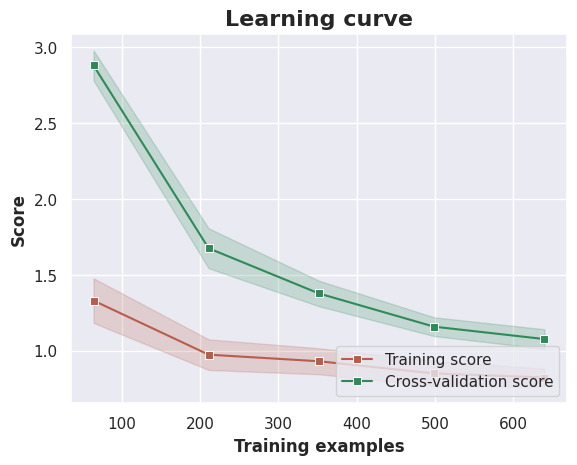

In [25]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve_optuna')
plt.show()

# Save model

In [26]:
model_path = os.path.join(MODEL_FOLDER, 'NN_optuna_model.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/Shareddrives/Project_ML_23/Nunzio/machine-learning-project/trained_models/cup2023/NN_optuna_model.joblib']